In [1]:
%load_ext watermark


In [2]:
import itertools as it

from Bio import Phylo as BioPhylo
import alifedata_phyloinformatics_convert as apc
import covasim as cv
from hstrat import _auxiliary_lib as hstrat_aux
from IPython.core.display import display, HTML
from matplotlib import patches as mpl_patches
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from slugify import slugify
from teeplot import teeplot as tp

from pylib._cv_infection_log_to_alstd_df import cv_infection_log_to_alstd_df
from pylib._generate_dummy_sequences import generate_dummy_sequences
from pylib._mask_mutations import mask_mutations
from pylib._mwu_kdeplot import mwu_kdeplot
from pylib._pairplot import pairplot
from pylib._seed_global_rngs import seed_global_rngs


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-04-29T18:14:31.404309+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1026-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib                        : 3.9.2
numpy                             : 2.1.2
teeplot                           : 1.4.2
alifedata_phyloinformatics_convert: 0.19.3
pandas                            : 2.2.3
covasim                           : 3.1.6
hstrat                            : 1.20.4
Bio                               : 1.85

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-04-08-dev-sequencescreen-pessimal"
teeplot_subdir


'2025-04-08-dev-sequencescreen-pessimal'

## Setup Params

Define `gamma` and `delta` strains, as well as accompanying lower-transmissibility `gamma'` and `delta'` strains.


In [5]:
pop_size = 20_000
num_days = 200
num_variants = 5  # 0th variant is wild-type
seed_global_rngs(1)


In [6]:
# from https://github.com/InstituteforDiseaseModeling/covasim/blob/fef033fed5a0ca71be9c4f773d75dce1d237e753/covasim/parameters.py
gamma = dict(
    rel_beta=2.05,  # Estimated to be 1.7-2.4-fold more transmissible than wild-type: https://science.sciencemag.org/content/early/2021/04/13/science.abh2644
    rel_symp_prob=1.0,
    rel_severe_prob=2.6,  # From https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2021.26.16.2100348
    rel_crit_prob=1.0,
    rel_death_prob=1.0,
)
gamma_ = {**gamma, "rel_beta": 0.5}  # lower-transmissibility variant

delta = dict(
    rel_beta=2.2,  # Estimated to be 1.25-1.6-fold more transmissible than B117: https://www.researchsquare.com/article/rs-637724/v1
    rel_symp_prob=1.0,
    rel_severe_prob=3.2,  # 2x more transmissible than alpha from https://mobile.twitter.com/dgurdasani1/status/1403293582279294983
    rel_crit_prob=1.0,
    rel_death_prob=1.0,
)
delta_ = {**delta, "rel_beta": 0.6}  # lower-transmissibility variant


In [7]:
# import gamma and then delta 30 days later
gamma = cv.variant(variant=gamma, label="gamma", days=0, n_imports=10)
delta = cv.variant(variant=delta, label="delta", days=30, n_imports=50)

# lower-transimissibility variants arise from spontaneous mutations, not imports
gamma_ = cv.variant(variant=gamma_, label="gamma'", days=0, n_imports=0)
delta_ = cv.variant(variant=delta_, label="delta'", days=0, n_imports=0)


## Prototype Within-host Dynamics Extension


In [8]:
class SyncWithinHost:

    _host_compartments: np.ndarray

    def __init__(
        self: "SyncWithinHost", pop_size: int, num_variants: int
    ) -> None:
        shape = (pop_size, num_variants)
        self._host_compartments = np.zeros(shape, dtype=float)

    def __call__(self: "SyncWithinHost", sim: cv.Sim) -> None:
        compartments = self._host_compartments
        people = sim.people
        random_p = np.random.rand(*people["infectious_variant"].shape)

        ## sync covasim to host compartments
        #######################################################################
        # zero out non-infectious/exposed compartments
        mask = ~(people["infectious"] | people["exposed"])
        compartments[mask, :] = 0.0

        # ensure host compartments are initialized w/ covasim infectious variant
        for variant in range(1, num_variants):
            compartments[:, variant] = np.maximum(
                people["infectious_variant"] == variant,
                compartments[:, variant],
            )

        # update host compartments
        #######################################################################
        # grow strains
        compartments[:, 1] *= 2.0
        compartments[:, 2] *= 1.3  # slower growth
        compartments[:, 3] *= 2.0
        compartments[:, 4] *= 1.3  # lslower growth

        compartments /= (
            np.maximum(
                compartments.sum(axis=1, keepdims=True),
                100.0,
            )
            / 100.0
        )

        # introduce low-transmissibility variants thru spontaneous mutation
        # of high-transmissibility variants
        # e.g., gamma -> gamma' and delta -> delta'
        for lowtran_variant in 2, 4:
            p = 1.0 - np.power(0.99, compartments[:, lowtran_variant - 1])
            compartments[:, lowtran_variant] = np.maximum(
                random_p < p,
                compartments[:, lowtran_variant],
            )

        ## sync host compartments to covasim "infectious variant"
        #######################################################################
        # sample current infectious variant from compartments
        compartments_ = compartments.copy()
        compartments_ *= np.random.rand(*compartments.shape)
        compartments_[1, :] *= 1.5  # higher-transmissiblity bonus
        compartments_[3, :] *= 1.5  # higher-transmissiblity bonus
        sampled_strains = np.where(
            compartments_.any(axis=1),
            np.argmax(compartments_, axis=1),
            np.nan,
        )

        # update current covasim infectious variant
        people["infectious_variant"] = np.where(
            ~np.isnan(people["infectious_variant"]),
            sampled_strains,
            people["infectious_variant"],
        )


## Run Example Simulation


In [9]:
sim = cv.Sim(
    interventions=[SyncWithinHost(pop_size, num_variants)],
    n_days=num_days,
    # adapted from https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_immunity.html
    nab_decay=dict(
        form="nab_growth_decay",
        growth_time=21,
        decay_rate1=0.1,
        decay_time1=47,
        decay_rate2=0.05,
        decay_time2=106,
    ),
    pop_infected=0,  # disable wild-type strain
    pop_size=pop_size,
    variants=[gamma, gamma_, delta, delta_],
    rand_seed=1,
)
sim.run()


Initializing sim with 20000 people for 200 days
  Running 2020-03-01 ( 0/200) (0.09 s)  ———————————————————— 0%
  Running 2020-03-11 (10/200) (0.17 s)  •——————————————————— 5%
  Running 2020-03-21 (20/200) (0.25 s)  ••—————————————————— 10%
  Running 2020-03-31 (30/200) (0.35 s)  •••————————————————— 15%
  Running 2020-04-10 (40/200) (0.48 s)  ••••———————————————— 20%
  Running 2020-04-20 (50/200) (0.65 s)  •••••——————————————— 25%
  Running 2020-04-30 (60/200) (0.83 s)  ••••••—————————————— 30%
  Running 2020-05-10 (70/200) (1.01 s)  •••••••————————————— 35%
  Running 2020-05-20 (80/200) (1.17 s)  ••••••••———————————— 40%
  Running 2020-05-30 (90/200) (1.34 s)  •••••••••——————————— 45%
  Running 2020-06-09 (100/200) (1.51 s)  ••••••••••—————————— 50%
  Running 2020-06-19 (110/200) (1.68 s)  •••••••••••————————— 55%
  Running 2020-06-29 (120/200) (1.86 s)  ••••••••••••———————— 60%
  Running 2020-07-09 (130/200) (2.04 s)  •••••••••••••——————— 65%
  Running 2020-07-19 (140/200) (2.21 s) 

Sim(<no label>; 2020-03-01 to 2020-09-17; pop: 20000 random; epi: 77897⚙, 557☠)

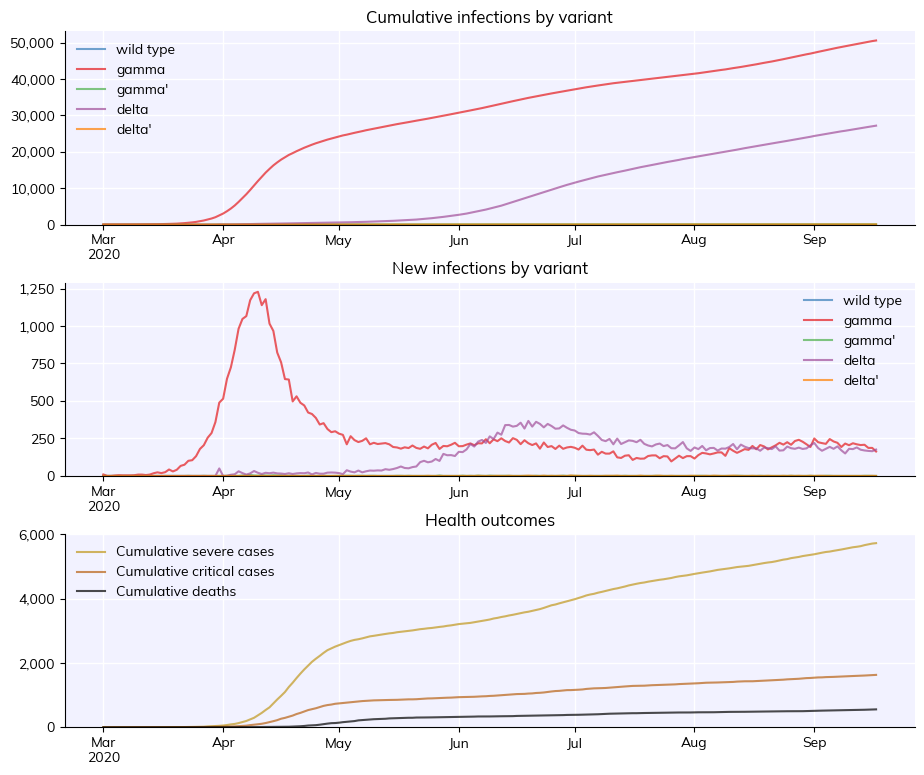

teeplots/2025-04-08-dev-sequencescreen-pessimal/viz=plot+what=within-host+ext=.pdf
teeplots/2025-04-08-dev-sequencescreen-pessimal/viz=plot+what=within-host+ext=.png


<Figure size 640x480 with 0 Axes>

Ellipsis

In [10]:
tp.tee(
    sim.plot,
    "variant",
    teeplot_outattrs={"what": "within-host"},
    teeplot_subdir=teeplot_subdir,
)
...


## Visualize Pathogen Phylogeny


In [11]:
phylo_df = cv_infection_log_to_alstd_df(sim.people.infection_log)

phylo_df = hstrat_aux.alifestd_downsample_tips_asexual(
    phylo_df, n_downsample=200
)

phylo_tree = apc.alife_dataframe_to_biopython_tree(
    phylo_df,
    setattrs=["variant"],
    setup_branch_lengths=True,
)

node_colors = {
    "delta": "blue",
    "delta'": "green",
    "gamma": "red",
    "gamma'": "purple",
}
for node in phylo_tree.find_clades():
    node.color = node_colors[node.variant]


2025-04-08-dev-sequencescreen-pessimal/viz=draw-biophylo+what=within-host+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/viz=draw-biophylo+what=within-host+ext=.png


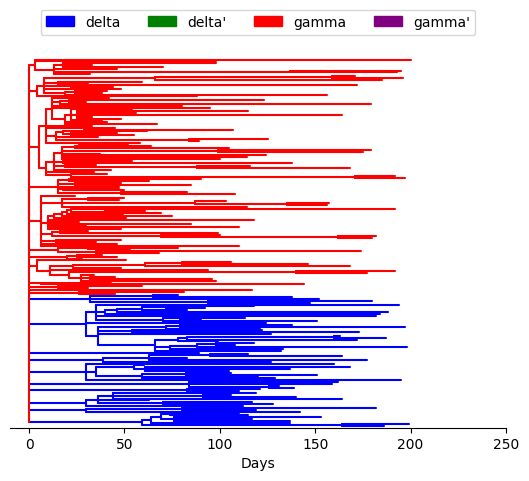

In [12]:
def draw_biophylo(tree: BioPhylo.BaseTree, **kwargs) -> plt.Axes:
    ax = plt.gca()
    BioPhylo.draw(tree, axes=ax, do_show=False, **kwargs)
    return ax


with tp.teed(
    draw_biophylo,
    phylo_tree,
    teeplot_outattrs={"what": "within-host"},
    teeplot_outdir=teeplot_subdir,
) as ax:
    ax.set_xlabel("Days")
    ax.yaxis.set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    legend_handles = [
        mpl_patches.Patch(color=color, label=variant)
        for variant, color in node_colors.items()
    ]
    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=4,
    )


## Extract Pathogen Phylogeny Topology


In [13]:
phylo_df = cv_infection_log_to_alstd_df(sim.people.infection_log)
phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)


In [14]:
# clean tree topology
with hstrat_aux.log_context_duration(
    "alifestd_add_inner_leaves",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_add_inner_leaves(phylo_df, mutate=True)
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_downsample_tips_asexual",
    logger=print,
):
    # phylo_df = hstrat_aux.alifestd_downsample_tips_asexual(
    #     phylo_df,
    #     n_downsample=20_000,
    # )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_splay_polytomies",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_splay_polytomies(phylo_df, mutate=True)
    phylo_df.drop(columns=["is_leaf"], inplace=True, errors="ignore")
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_collapse_unifurcations",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_collapse_unifurcations(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_delete_unifurcating_roots_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_delete_unifurcating_roots_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

# more statistics
with hstrat_aux.log_context_duration("alifestd_mark_*", logger=print):
    phylo_df = hstrat_aux.alifestd_mark_leaves(phylo_df, mutate=True)
    phylo_df = hstrat_aux.alifestd_mark_num_leaves_sibling_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_mark_num_leaves_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_mark_roots(phylo_df, mutate=True)

phylo_df["is_leaf"].value_counts()


enter log_context_duration for alifestd_add_inner_leaves
exit log_context_duration for alifestd_add_inner_leaves
!!! {"alifestd_add_inner_leaves": 0.02062535285949707}
enter log_context_duration for alifestd_downsample_tips_asexual
exit log_context_duration for alifestd_downsample_tips_asexual
!!! {"alifestd_downsample_tips_asexual": 0.00029778480529785156}
enter log_context_duration for alifestd_splay_polytomies
exit log_context_duration for alifestd_splay_polytomies
!!! {"alifestd_splay_polytomies": 2.037083387374878}
enter log_context_duration for alifestd_collapse_unifurcations
exit log_context_duration for alifestd_collapse_unifurcations
!!! {"alifestd_collapse_unifurcations": 0.07451057434082031}
enter log_context_duration for alifestd_delete_unifurcating_roots_asexual
exit log_context_duration for alifestd_delete_unifurcating_roots_asexual
!!! {"alifestd_delete_unifurcating_roots_asexual": 0.06305742263793945}
enter log_context_duration for alifestd_mark_*
exit log_context_durat

is_leaf
True     77897
False    77896
Name: count, dtype: int64

## Compute Sister Statistics


In [15]:
min_leaves = 4
work_mask = (phylo_df["num_leaves"] > min_leaves) & (
    phylo_df["num_leaves_sibling"] > min_leaves
)
# sister statistics
with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_subtended_duration_ratio_sister_asexual",
    logger=print,
):
    phylo_df = (
        hstrat_aux.alifestd_mark_clade_subtended_duration_ratio_sister_asexual(
            phylo_df, mutate=True
        )
    )
    phylo_df["clade duration ratio"] = np.log(
        phylo_df["clade_subtended_duration_ratio_sister"]
    )

with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_logistic_growth_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_logistic_growth_sister_asexual(
        phylo_df, mutate=True, parallel_backend="loky", work_mask=work_mask
    )
    phylo_df["clade growth ratio"] = phylo_df["clade_logistic_growth_sister"]

with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_leafcount_ratio_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_leafcount_ratio_sister_asexual(
        phylo_df, mutate=True
    )
    phylo_df["clade size ratio"] = np.log(
        phylo_df["clade_leafcount_ratio_sister"]
    )


enter log_context_duration for alifestd_mark_clade_subtended_duration_ratio_sister_asexual
exit log_context_duration for alifestd_mark_clade_subtended_duration_ratio_sister_asexual
!!! {"alifestd_mark_clade_subtended_duration_ratio_sister_asexual": 0.14235496520996094}
enter log_context_duration for alifestd_mark_clade_logistic_growth_sister_asexual


/usr/local/lib/python3.10/dist-packages/hstrat/_auxiliary_lib/_alifestd_mark_clade_subtended_duration_ratio_sister_asexual.py:52: RuntimeWarning: divide by zero encountered in divide
  phylogeny_df["clade_subtended_duration"].values
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


exit log_context_duration for alifestd_mark_clade_logistic_growth_sister_asexual
!!! {"alifestd_mark_clade_logistic_growth_sister_asexual": 7.316723585128784}
enter log_context_duration for alifestd_mark_clade_leafcount_ratio_sister_asexual
exit log_context_duration for alifestd_mark_clade_leafcount_ratio_sister_asexual
!!! {"alifestd_mark_clade_leafcount_ratio_sister_asexual": 0.0364537239074707}


## Generate Pathogen Dummy Sequences


In [16]:
def mutator(
    ancestor_sequence: str,
    variant: str,
    ancestor_variant: str,
    origin_time: float,
    ancestor_origin_time: float,
) -> str:

    seq_array = np.array(list(ancestor_sequence))

    # Handle the special mutation rules for transmission-harming trait
    if ("'" not in ancestor_variant) and ("'" in variant):
        seq_array[0] = "X"

    assert not (("'" in ancestor_variant) and ("'" not in variant))

    # Compute elapsed time and use it to calculate a mutation probability.
    elapsed_time = origin_time - ancestor_origin_time
    mu = 0.002
    mutation_probability = 1 - np.exp(-mu * elapsed_time)

    # For indices 1 and onward, perform mutations in a vectorized manner.
    # Create an array of indices representing positions 1..(n-1).
    tail_indices = np.arange(1, len(seq_array))

    # Determine which positions should mutate.
    mutate_bool = np.random.rand(len(tail_indices)) < mutation_probability
    mutate_indices = tail_indices[mutate_bool]

    # For the positions that meet the mutation condition, assign a random choice between "A" and "B".
    seq_array[mutate_indices] = np.random.choice(
        ["A", "B"], size=mutate_indices.shape[0]
    )

    # Return the mutated sequence as a string.
    return "".join(seq_array)


In [17]:
ancestral_sequence = "A" * 1000
dummy_sequences = generate_dummy_sequences(
    phylo_df,
    ancestral_sequence=ancestral_sequence,
    mutator=mutator,
)
dummy_sequences[-10:]


['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAABAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABBAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB

## Extract Mutation Masks, Identify Mutaiton-Defined Clades


In [18]:
mutation_masks = mask_mutations(
    ancestral_sequence=ancestral_sequence,
    derived_sequences=dummy_sequences,
)
str(mutation_masks)[:150]


"{(0, 'A', 'X'): array([False, False, False, ..., False, False, False]), (1, 'A', 'B'): array([False, False, False, ..., False, False, False]), (2, 'A'"

In [19]:
def screen_mutation_defined_nodes(
    phylo_df: pd.DataFrame,
    has_mutation: np.ndarray,
) -> dict:
    phylo_df.reset_index(drop=True, inplace=True)
    # trait screening --- trait-defined
    screen_trait_defined_fisher = (
        hstrat_aux.alifestd_screen_trait_defined_clades_fisher_asexual(
            phylo_df,
            mutate=True,
            mask_trait_absent=(~has_mutation) & phylo_df["is_leaf"],
            mask_trait_present=has_mutation & phylo_df["is_leaf"],
        )
        < 0.2
    )
    # pick lowest significant node
    assert hstrat_aux.alifestd_is_working_format_asexual(phylo_df)
    screen_trait_defined_fisher[
        phylo_df["ancestor_id"].to_numpy()
    ] &= ~screen_trait_defined_fisher

    screen_trait_defined_naive = (
        hstrat_aux.alifestd_screen_trait_defined_clades_naive_asexual(
            phylo_df,
            mutate=True,
            mask_trait_absent=(~has_mutation) & phylo_df["is_leaf"],
            mask_trait_present=has_mutation & phylo_df["is_leaf"],
        )
    )
    return {
        "combined": screen_trait_defined_fisher & screen_trait_defined_naive,
        "fisher": screen_trait_defined_fisher,
        "naive": screen_trait_defined_naive,
    }


## Process Pathogen Phylogeny Statistics --- TFP


In [20]:
mutation = (0, "A", "X")
display(HTML(f"<h2>{mutation=}</h2>"))

# screen phylogeny
with hstrat_aux.log_context_duration(
    "screen_mutation_defined_nodes",
    logger=print,
):
    screen = screen_mutation_defined_nodes(
        phylo_df.copy(),
        has_mutation=mutation_masks[mutation],
    )

print(screen["fisher"].sum(), screen["naive"].sum(), screen["combined"].sum())


enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.17919659614562988}
170 109 44


len(draw_df)=186
2025-04-08-dev-sequencescreen-pessimal/color=defining-mut-clades+viz=draw-biophylo+what=0-a-x+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/color=defining-mut-clades+viz=draw-biophylo+what=0-a-x+ext=.png


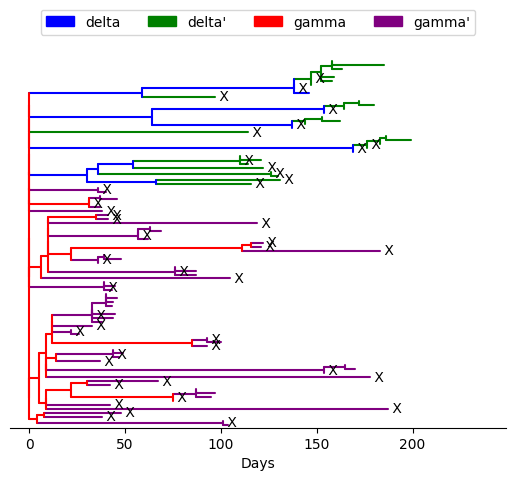

In [21]:
# draw screened phylogeny, color by clades
draw_df = phylo_df.copy()
draw_df["is_defining"] = screen["combined"]
draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
    draw_df, ancestor_mask=screen["combined"], mutate=True
)
draw_df["is_screened"] = draw_df["alifestd_mask_descendants_asexual"]
draw_df["extant"] = draw_df["is_screened"]
draw_df = hstrat_aux.alifestd_prune_extinct_lineages_asexual(draw_df)
draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
draw_df = hstrat_aux.alifestd_collapse_unifurcations(draw_df)
draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
print(f"{len(draw_df)=}")
draw_tree = apc.alife_dataframe_to_biopython_tree(
    draw_df,
    setattrs=["variant", "is_defining"],
    setup_branch_lengths=True,
)
for node in draw_tree.find_clades():
    node.color = [
        node_colors[node.variant],
        node_colors[node.variant],
        # "magenta",
    ][node.is_defining]

with tp.teed(
    draw_biophylo,
    draw_tree,
    label_func=lambda node: [None, "X"][node.is_defining],
    teeplot_outattrs={
        "color": "defining-mut-clades",
        "what": slugify(str(mutation)),
    },
    teeplot_outdir=teeplot_subdir,
) as ax:
    ax.set_xlabel("Days")
    ax.yaxis.set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    legend_handles = [
        mpl_patches.Patch(color=color, label=variant)
        for variant, color in node_colors.items()
    ]
    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=4,
    )


len(draw_df)=1514
2025-04-08-dev-sequencescreen-pessimal/color=screened-sister+viz=draw-biophylo+what=0-a-x+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/color=screened-sister+viz=draw-biophylo+what=0-a-x+ext=.png


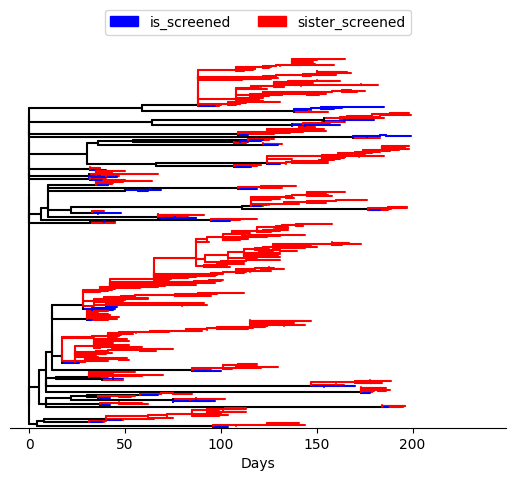

In [22]:
# draw screened phylogeny, color byscreened status
draw_df = phylo_df.copy()
draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
    draw_df, ancestor_mask=screen["combined"], mutate=True
)
draw_df["is_screened"] = draw_df["alifestd_mask_descendants_asexual"]
draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
    draw_df,
    ancestor_mask=screen["combined"][draw_df["sister_id"]],
    mutate=True,
)
draw_df["sister_screened"] = draw_df["alifestd_mask_descendants_asexual"]
draw_df["extant"] = draw_df["is_screened"] | draw_df["sister_screened"]
draw_df = hstrat_aux.alifestd_prune_extinct_lineages_asexual(draw_df)
draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
draw_df = hstrat_aux.alifestd_collapse_unifurcations(draw_df)
draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
print(f"{len(draw_df)=}")
draw_tree = apc.alife_dataframe_to_biopython_tree(
    draw_df,
    setattrs=["is_screened", "sister_screened"],
    setup_branch_lengths=True,
)
for node in draw_tree.find_clades():
    node.color = [["black", "red"], ["blue", "green"],][
        node.is_screened
    ][node.sister_screened]

with tp.teed(
    draw_biophylo,
    draw_tree,
    teeplot_outattrs={
        "color": "screened-sister",
        "what": slugify(str(mutation)),
    },
    teeplot_outdir=teeplot_subdir,
) as ax:
    ax.set_xlabel("Days")
    ax.yaxis.set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    legend_handles = [
        mpl_patches.Patch(color=color, label=variant)
        for variant, color in {
            "is_screened": "blue",
            "sister_screened": "red",
        }.items()
    ]
    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
    )


In [23]:
# prep data
data_df = phylo_df.copy()
data_df["fisher trait-defined"] = screen["fisher"]
data_df["naive trait-defined"] = screen["naive"]
data_df["combined trait-defined"] = screen["combined"]
screen_clade_size = (data_df["num_leaves"] > min_leaves) & (
    data_df["num_leaves_sibling"] > min_leaves
)
data_df = data_df[screen_clade_size & ~data_df["is_root"]].copy()


combined trait-defined
False    12615
True         1
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=0-a-x+viz=mwu-kdeplot+x=num-leaves+ext=.pdf


/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)


2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=0-a-x+viz=mwu-kdeplot+x=num-leaves+ext=.png


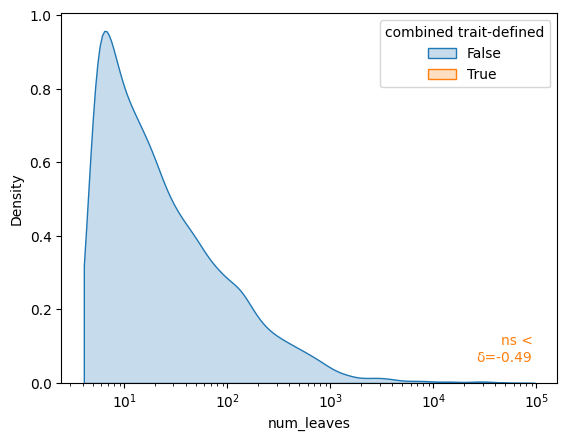

/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_pairplot.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_pairplot.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_pairplot.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=0-a-x+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=0-a-x+viz=pairplot+ext=.png


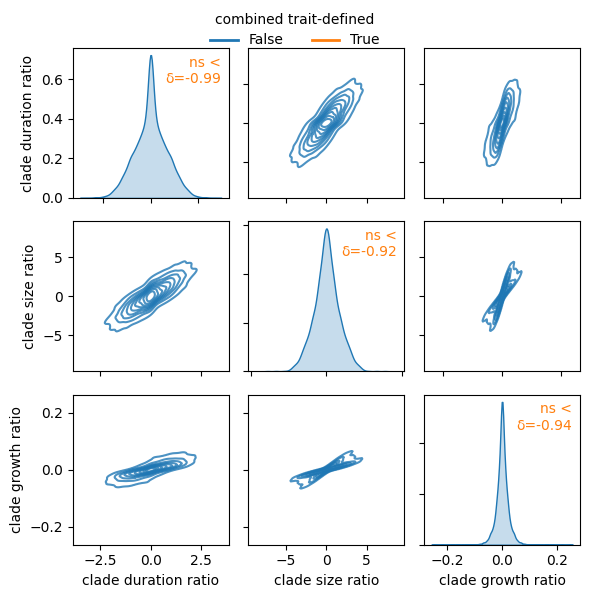

In [24]:
# plot distributions
for screen_trait_defined in (
    # "fisher trait-defined",
    # "naive trait-defined",
    "combined trait-defined",
):
    print(data_df[screen_trait_defined].value_counts())
    tp.tee(
        mwu_kdeplot,
        data_df,
        x="num_leaves",
        hue=screen_trait_defined,
        common_norm=False,
        cut=True,
        fill=True,
        log_scale=(True, False),
        teeplot_outattrs={"mutation": slugify(str(mutation))},
        teeplot_outdir=teeplot_subdir,
    )
    tp.tee(
        pairplot,
        data_df,
        hue=screen_trait_defined,
        vars_to_plot=[
            "clade duration ratio",
            "clade size ratio",
            "clade growth ratio",
        ],
        log_vars=[],
        teeplot_outattrs={"mutation": slugify(str(mutation))},
        teeplot_outdir=teeplot_subdir,
    )


## Process Pathogen Phylogeny Statistics --- non-TFP


enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.1903839111328125}
1470 1046 600
combined trait-defined
False    12481
True       135
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=1-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=1-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


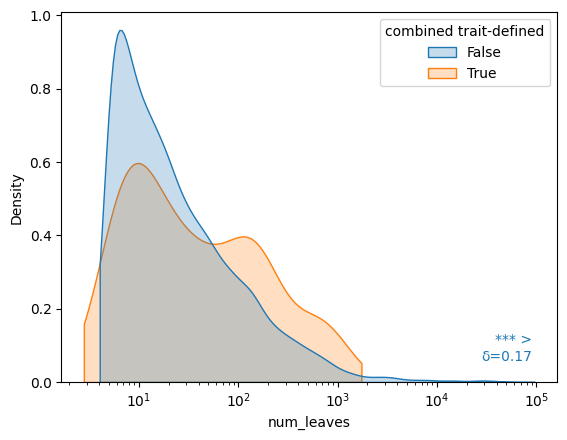

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=1-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=1-a-b+viz=pairplot+ext=.png


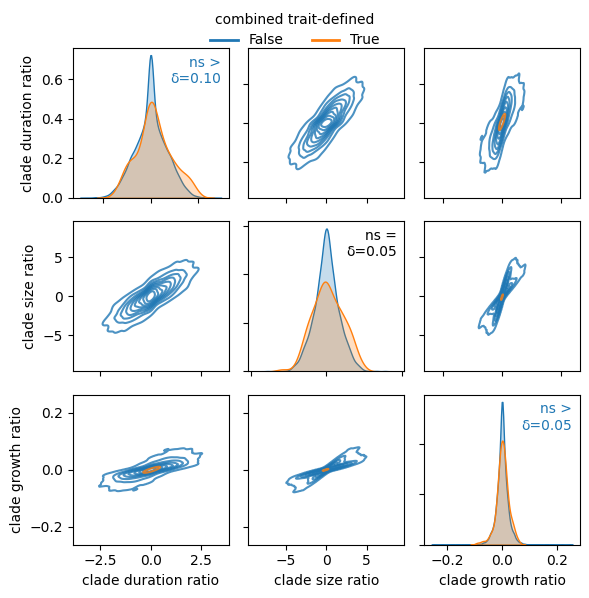

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.17415595054626465}
1354 1032 554
combined trait-defined
False    12493
True       123
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=2-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=2-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


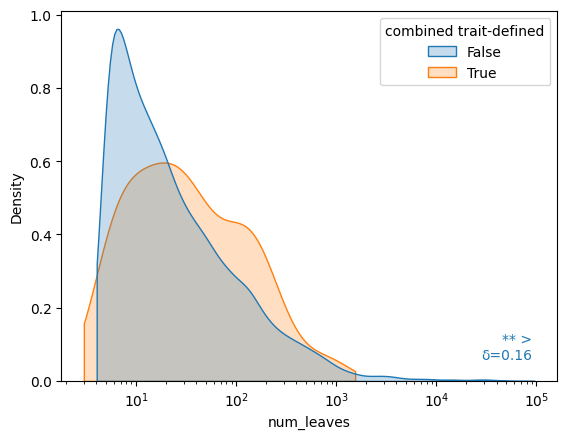

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=2-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=2-a-b+viz=pairplot+ext=.png


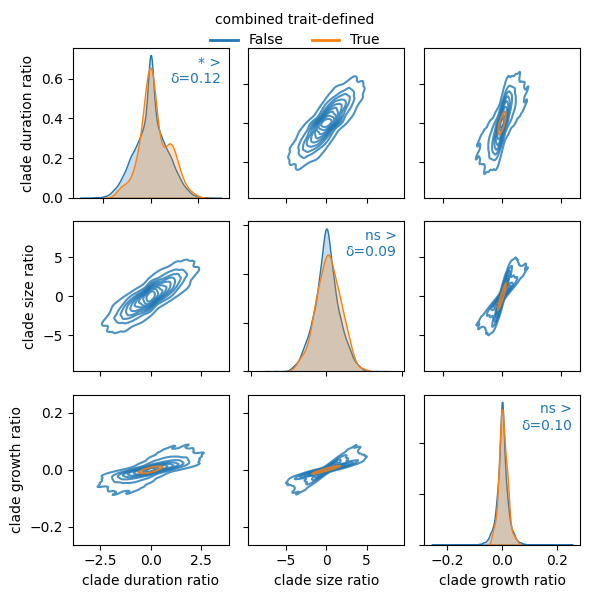

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.16903090476989746}
1315 954 495
combined trait-defined
False    12515
True       101
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=3-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=3-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


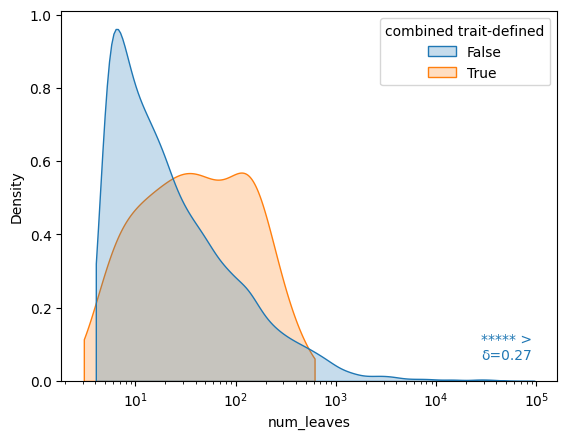

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=3-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=3-a-b+viz=pairplot+ext=.png


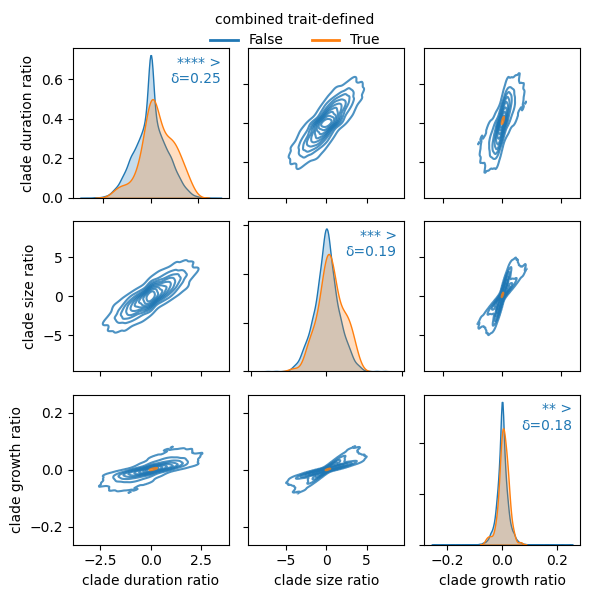

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.18077683448791504}
1354 1024 546
combined trait-defined
False    12479
True       137
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=4-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=4-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


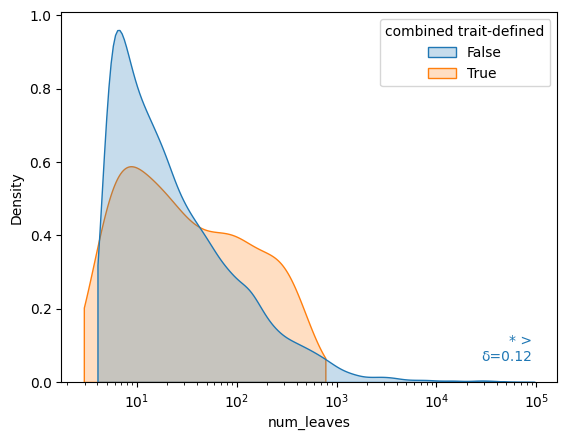

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=4-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=4-a-b+viz=pairplot+ext=.png


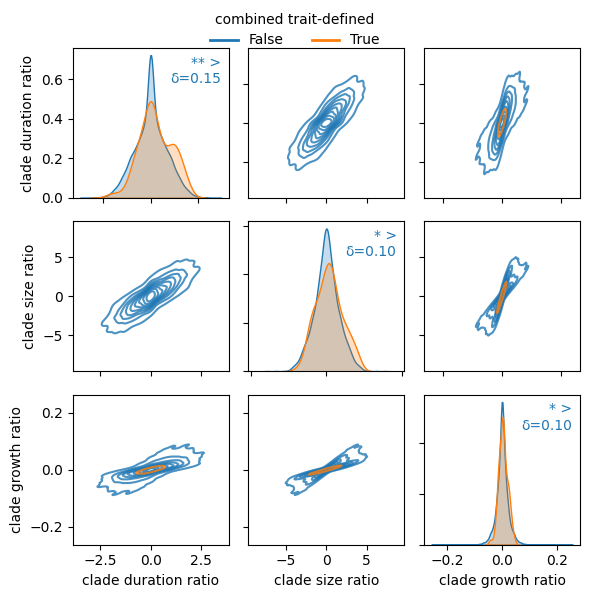

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.1774768829345703}
1283 937 463
combined trait-defined
False    12515
True       101
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=5-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=5-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


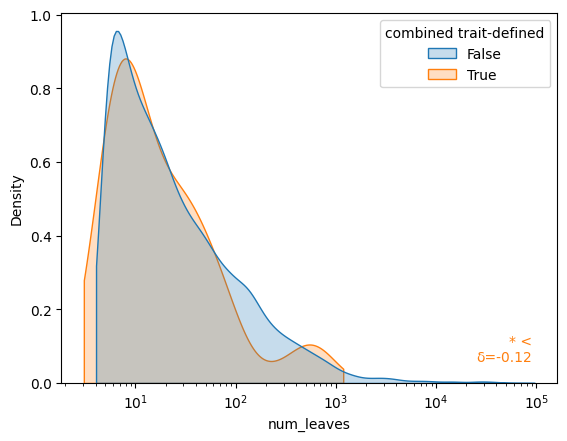

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=5-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=5-a-b+viz=pairplot+ext=.png


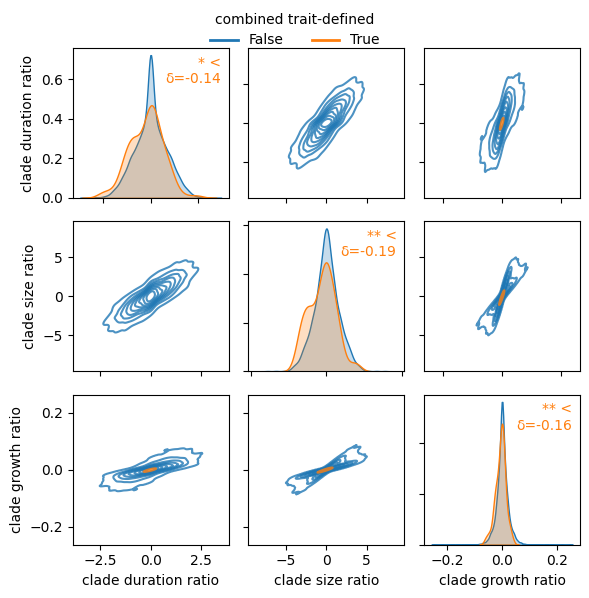

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.17316293716430664}
1359 1015 542
combined trait-defined
False    12491
True       125
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=6-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=6-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


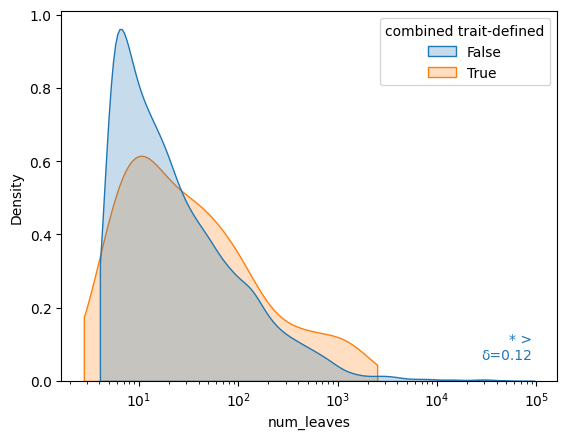

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=6-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=6-a-b+viz=pairplot+ext=.png


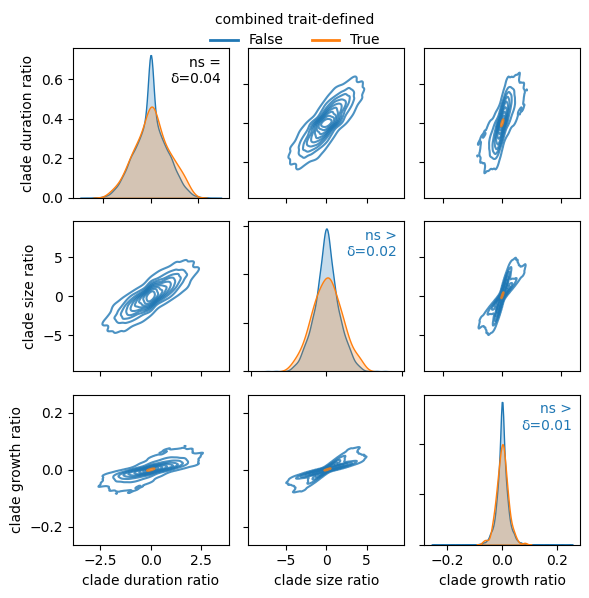

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.17667198181152344}
1343 1007 572
combined trait-defined
False    12487
True       129
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=7-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=7-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


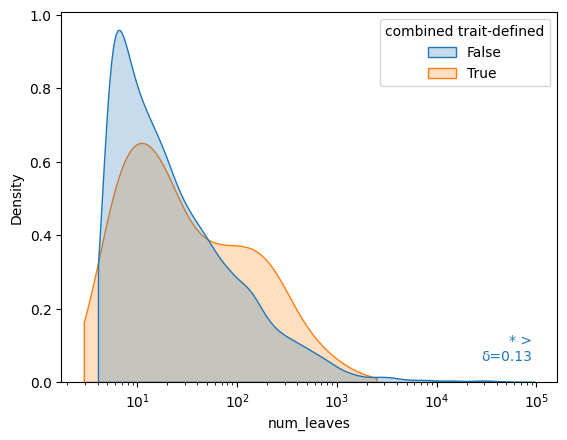

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=7-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=7-a-b+viz=pairplot+ext=.png


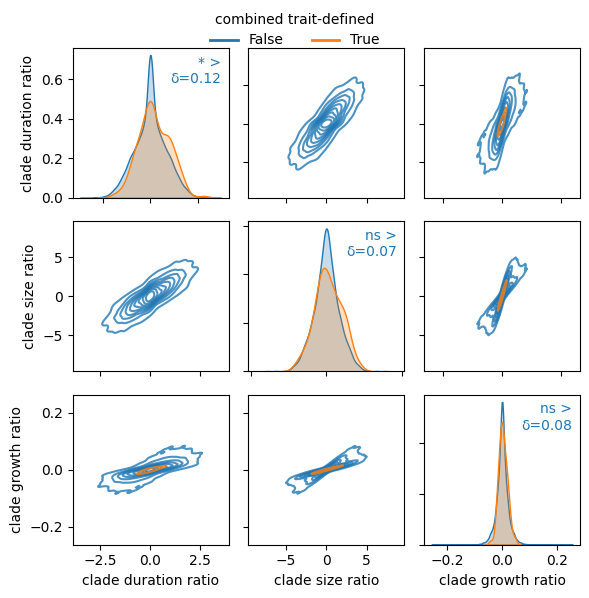

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.17561030387878418}
1378 1025 532
combined trait-defined
False    12501
True       115
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=8-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=8-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


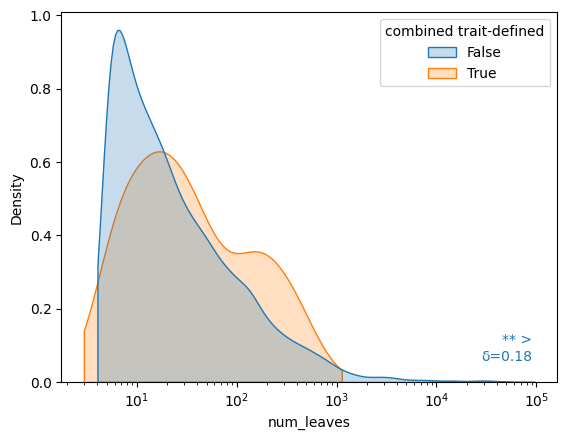

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=8-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=8-a-b+viz=pairplot+ext=.png


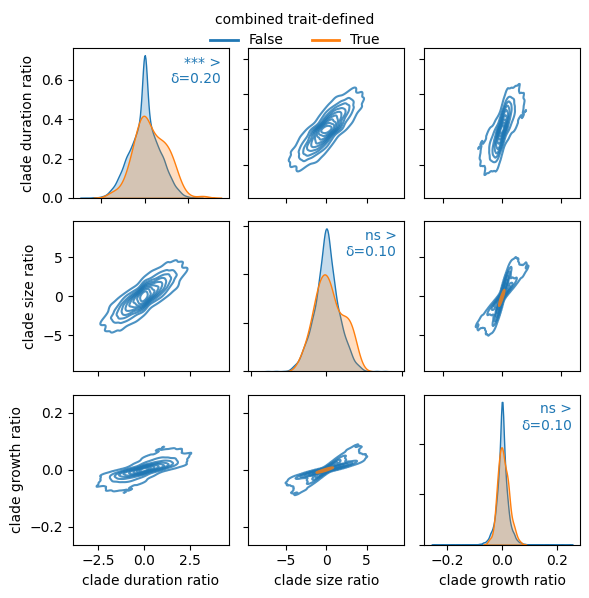

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.17858004570007324}
1249 977 501
combined trait-defined
False    12503
True       113
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=9-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=9-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


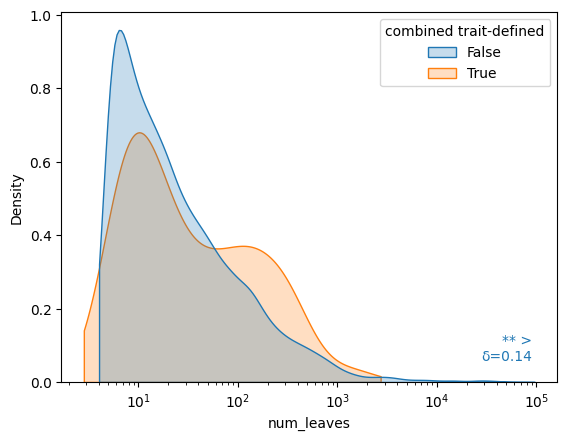

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=9-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=9-a-b+viz=pairplot+ext=.png


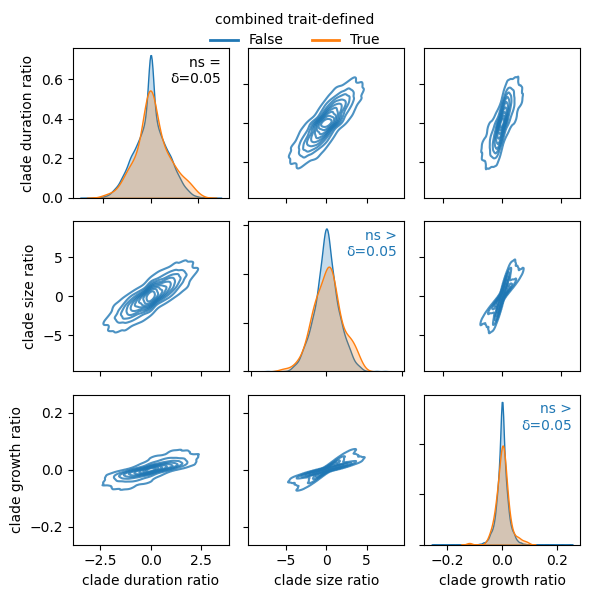

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.17863798141479492}
1371 990 531
combined trait-defined
False    12490
True       126
Name: count, dtype: int64
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=10-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=10-a-b+viz=mwu-kdeplot+x=num-leaves+ext=.png


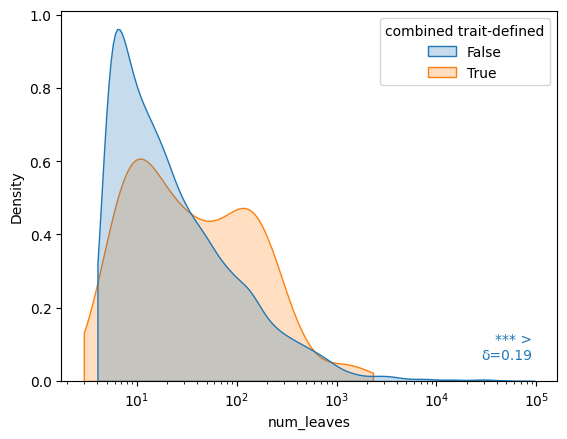

2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=10-a-b+viz=pairplot+ext=.pdf
2025-04-08-dev-sequencescreen-pessimal/hue=combined-trait-defined+mutation=10-a-b+viz=pairplot+ext=.png


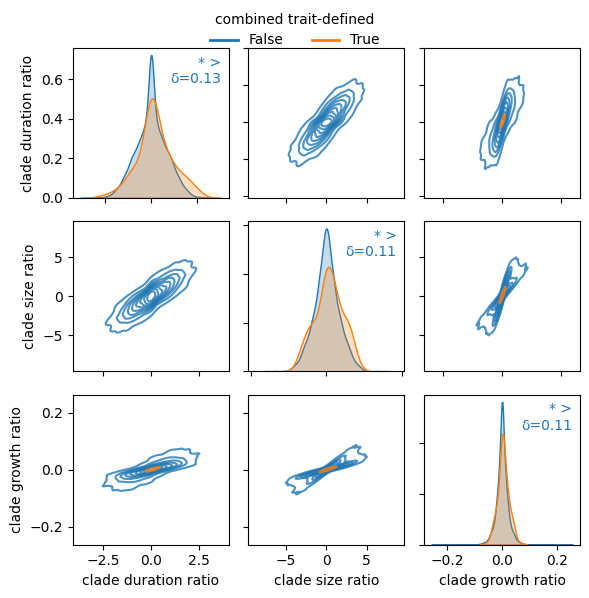

In [25]:
for mutation in it.islice(
    ((site, from_, to) for site, from_, to in mutation_masks if site > 0),
    10,
):
    display(HTML(f"<h2>{mutation=}</h2>"))

    with hstrat_aux.log_context_duration(
        "screen_mutation_defined_nodes",
        logger=print,
    ):
        screen = screen_mutation_defined_nodes(
            phylo_df.copy(),
            has_mutation=mutation_masks[mutation],
        )

    print(
        screen["fisher"].sum(), screen["naive"].sum(), screen["combined"].sum()
    )

    data_df = phylo_df.copy()
    data_df["fisher trait-defined"] = screen["fisher"]
    data_df["naive trait-defined"] = screen["naive"]
    data_df["combined trait-defined"] = screen["combined"]
    screen_clade_size = (data_df["num_leaves"] > 4) & (
        data_df["num_leaves_sibling"] > 4
    )
    data_df = data_df[screen_clade_size & ~data_df["is_root"]].copy()

    for screen_trait_defined in (
        # "fisher trait-defined",
        # "naive trait-defined",
        "combined trait-defined",
    ):
        print(data_df[screen_trait_defined].value_counts())
        tp.tee(
            mwu_kdeplot,
            data_df,
            x="num_leaves",
            hue=screen_trait_defined,
            common_norm=False,
            cut=True,
            fill=True,
            log_scale=(True, False),
            teeplot_outattrs={"mutation": slugify(str(mutation))},
            teeplot_outdir=teeplot_subdir,
        )
        tp.tee(
            pairplot,
            data_df,
            hue=screen_trait_defined,
            vars_to_plot=[
                "clade duration ratio",
                "clade size ratio",
                "clade growth ratio",
            ],
            log_vars=[],
            teeplot_outattrs={"mutation": slugify(str(mutation))},
            teeplot_outdir=teeplot_subdir,
        )
